# Amazon Fine Food Reviews Prediction using KNN


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

### Objective:
To find the best model which can accurately predict whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).



#### Dataset information<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review





# [1]. Reading Data

## [1.1] Loading the data

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:

con = sqlite3.connect('database.sqlite') 


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it is necessary to remove duplicates in order to get unbiased results for the analysis of the data.<br>
The method used for the same is that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.64

 It is possible that the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence they need to be removed from calcualtions

In [21]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(9564, 10)


1    7976
0    1588
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [13]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
15 month old loves to eat them on the go! They seem great for a healthy, quick, and easy snack!
These chips are truly amazing. They have it all. They're light, crisp, great tasting, nice texture, AND they're all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldn't belive my taste buds. That's why I excited why I saw them here on Amazon, and decided to buy a case!
These tablets definitely made things sweeter -- like lemons, limes, and grapefruit.  But it wasn't to the point of sheer amazement.  They also had an interesting effect on cheeses and vinegar, but still did virtually nothing for beer and wine. The tablets are a bit pricey but they do work.  If you've got extra money, sure, give them a try, but if you're looking for some amazing way to get your kids to eat broccoli or something along those lines then this is not the answer. F

In [14]:
# remove urls from text python: 
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [21]:
# remove all tags from an element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!
15 month old loves to eat them on the go! They seem great for a healthy, quick, and easy snack!
These chips are truly amazing They have it all They are light crisp great tasting nice texture AND they are all natural AND low in fat and sodium Need I say more I recently bought a bag of them at a regular grocery store and could not belive my taste buds That is why I excited why I saw them here on Amazon and decided to buy a case 
These tablets definitely made things sweeter -- like lemons, limes, and grapefruit.  But it wasn't to the point of sheer amazement.  They also had an interesting effect on cheeses and vinegar, but still did virtually nothing for beer and wine. The tablets are a bit pricey but they do work.  If you've got extra money, sure, give them a try, but if you're looking for some amazing way to get your kids to eat broccoli or something along those lines then this is not the answer. Fun experime

In [22]:
# decontraction of words
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

These chips are truly amazing They have it all They are light crisp great tasting nice texture AND they are all natural AND low in fat and sodium Need I say more I recently bought a bag of them at a regular grocery store and could not belive my taste buds That is why I excited why I saw them here on Amazon and decided to buy a case 


In [24]:
#remove words with numbers 
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [25]:
#remove spacial character 
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

These chips are truly amazing They have it all They are light crisp great tasting nice texture AND they are all natural AND low in fat and sodium Need I say more I recently bought a bag of them at a regular grocery store and could not belive my taste buds That is why I excited why I saw them here on Amazon and decided to buy a case 


In [26]:
# removing stopwords

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [27]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 9564/9564 [00:08<00:00, 1078.95it/s]


In [29]:
preprocessed_reviews[1500]

'chips truly amazing light crisp great tasting nice texture natural low fat sodium need say recently bought bag regular grocery store could not belive taste buds excited saw amazon decided buy case'

# [4] Featurization

## [4.1] BAG OF WORDS

In [30]:
#BoW
count_vect = CountVectorizer() 
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print(final_counts)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])
print(final['Score'])

some feature names  ['aa', 'aaaa', 'aahhhs', 'ab', 'aback', 'abandon', 'abates', 'abberline', 'abbott', 'abby']
  (0, 1104)	1
  (0, 1266)	1
  (0, 2094)	1
  (0, 6183)	1
  (0, 7003)	1
  (0, 10661)	1
  (0, 12388)	1
  (0, 14095)	1
  (0, 17202)	1
  (0, 17396)	1
  (1, 1007)	1
  (1, 3612)	1
  (1, 6183)	1
  (1, 6648)	1
  (1, 10473)	1
  (1, 12286)	1
  (1, 12388)	1
  (1, 13523)	1
  (1, 15363)	1
  (1, 16572)	1
  (1, 16674)	1
  (1, 17090)	1
  (1, 17396)	1
  (2, 1275)	1
  (2, 2155)	1
  :	:
  (9562, 16293)	1
  (9562, 16675)	1
  (9562, 17202)	1
  (9562, 17213)	1
  (9562, 17623)	1
  (9562, 17644)	1
  (9563, 5036)	1
  (9563, 5038)	1
  (9563, 8671)	1
  (9563, 9211)	1
  (9563, 9310)	1
  (9563, 9707)	1
  (9563, 9979)	1
  (9563, 10780)	1
  (9563, 11149)	1
  (9563, 12388)	1
  (9563, 12613)	1
  (9563, 12657)	1
  (9563, 12721)	1
  (9563, 12872)	1
  (9563, 12967)	1
  (9563, 15407)	1
  (9563, 15490)	1
  (9563, 16469)	1
  (9563, 16471)	1
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the sha


## [4.2] Bi-Grams and n-Grams.

In [31]:
#bi-gram, tri-gram and n-gram


count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (9564, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [35]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able feed', 'able figure', 'able find']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (46071, 27311)
the number of unique words including both unigrams and bigrams  27311


## [4.4] Word2Vec

In [32]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [36]:


    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('delicious'))
    print('='*50)
    print(w2v_model.wv.most_similar('pizza'))
    


[('mild', 0.9722992181777954), ('creamy', 0.9619771838188171), ('hint', 0.9606685638427734), ('light', 0.9587075114250183), ('refreshing', 0.9556902647018433), ('tangerine', 0.9543805122375488), ('anise', 0.9517003297805786), ('flavorful', 0.9511878490447998), ('sour', 0.9508317112922668), ('minty', 0.9479527473449707)]
[('dishes', 0.9957240223884583), ('jerk', 0.9955251216888428), ('salmon', 0.9949238300323486), ('thins', 0.9948557615280151), ('loaf', 0.9944993257522583), ('neither', 0.9940758943557739), ('poultry', 0.9939975738525391), ('granola', 0.9938778877258301), ('dressing', 0.9936305284500122), ('cows', 0.9934179782867432)]


In [37]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5652
sample words  ['used', 'fly', 'bait', 'seasons', 'ca', 'not', 'beat', 'great', 'product', 'available', 'traps', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 9564/9564 [00:22<00:00, 417.00it/s]


9564
50


#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [40]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 9564/9564 [02:29<00:00, 63.97it/s]


# [5] Applying KNN

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW<font color='red'> </font>

In [42]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [43]:
#Spliting Traing Test and CrossValidation
X=preprocessed_reviews
X=np.array(X)
y = np.array(final['Score'])
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3,random_state=1) 

In [44]:
#converting Reviews to Bag of words
count_vect = CountVectorizer()
final_X_tr=count_vect.fit_transform(X_tr)
final_X_test=count_vect.transform(X_test)
final_X_cv=count_vect.transform(X_cv)

In [45]:
#Calculating for finding Best K
roc_tr=[]
roc_cv=[]
k_value=[]
max_auc_score=0
K_best=0
for i in range(1,100,4):
    # instantiate learning model (k = 100)
    knn = KNeighborsClassifier(algorithm='brute',metric='minkowski',n_neighbors=i)

    # fitting the model on train data
    knn.fit(final_X_tr, y_tr)

    # predict the response on the crossvalidation 
    pred_cv = knn.predict_proba(final_X_cv)
    pred_cv=(pred_cv)[:,1]
    roc_cv.append(roc_auc_score(y_cv,pred_cv))
    
     # predict the response on the traininig
    pred_tr = knn.predict_proba(final_X_tr)
    pred_tr=(pred_tr)[:,1]
    roc_tr.append(roc_auc_score(y_tr,pred_tr))
    k_value.append(i)
    
    #finding best k using max value of auc score
    if roc_auc_score(y_cv,pred_cv)>max_auc_score:
        k_best=i
        max_auc_score=roc_auc_score(y_cv,pred_cv)
print(k_best)        
print(max_auc_score)
k1=k_best
auc1=max_auc_score

73
0.7299826736693918


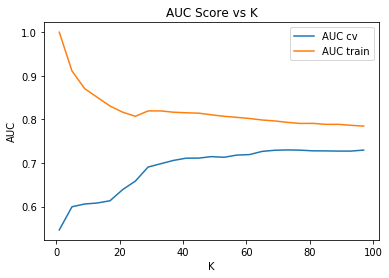

In [46]:
# plotting curve between K vs Train and Cross validation Data
plt.plot(k_value,roc_cv ,label="AUC cv")
plt.plot(k_value,roc_tr,label="AUC train")
plt.legend()
plt.title('AUC Score vs K')
plt.xlabel('K')
plt.ylabel('AUC')
plt.show()

In [47]:
# Training the model using best K    
knn = KNeighborsClassifier(algorithm='brute',metric='minkowski',n_neighbors=k_best)
knn.fit(final_X_tr, y_tr)
#predicting probability on Test data
pred_test = knn.predict_proba(final_X_test)
pred_test=(pred_test)[:,1]
#predicting probablity of Training data
pred_tr = knn.predict_proba(final_X_tr)
pred_tr=(pred_tr)[:,1]



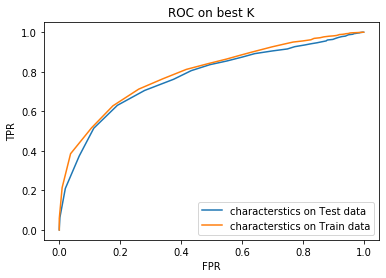

In [49]:
#Plotting Roc Curve

#fiding fpr and tpr on Training and Test Data
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_test)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr, pred_tr)

#plotting
plt.plot(fpr,tpr ,label="characterstics on Test data")
plt.plot(fpr1,tpr1 ,label="characterstics on Train data")
plt.legend()
plt.title('ROC on best K')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [50]:
#finding Confusion_matrix
predic=knn.predict(final_X_test)
conf_mat = confusion_matrix(y_test, predic)
print(conf_mat)

[[   5  498]
 [   3 2364]]


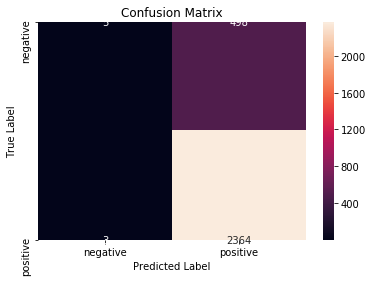

In [51]:
#plotting Confusion Matrix
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.1.2] Applying KNN brute force on TFIDF

In [52]:
#Spliting Traing Test and CrossValidation
X=preprocessed_reviews
X=np.array(X)
y = np.array(final['Score'])
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3,random_state=1) 

In [53]:
#converting Reviews to tf_idf_vec
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10 )
final_X_tr=tf_idf_vect.fit_transform(X_tr)
final_X_test=tf_idf_vect.transform(X_test)
final_X_cv=tf_idf_vect.transform(X_cv)

In [54]:
#Calculating for finding Best K
roc_tr=[]
roc_cv=[]
k_value=[]
max_auc_score=0
K_best=0
for i in range(1,100,4):
    # instantiate learning model (k = 100)
    knn = KNeighborsClassifier(algorithm='brute',metric='cosine',n_neighbors=i)

    # fitting the model on train data
    knn.fit(final_X_tr, y_tr)

    # predict the response on the crossvalidation 
    pred_cv = knn.predict_proba(final_X_cv)
    pred_cv=(pred_cv)[:,1]
    roc_cv.append(roc_auc_score(y_cv,pred_cv))
    
     # predict the response on the traininig
    pred_tr = knn.predict_proba(final_X_tr)
    pred_tr=(pred_tr)[:,1]
    roc_tr.append(roc_auc_score(y_tr,pred_tr))
    k_value.append(i)
    
    #finding best k using max value of auc score
    if roc_auc_score(y_cv,pred_cv)>max_auc_score:
        k_best=i
        max_auc_score=roc_auc_score(y_cv,pred_cv)
print(k_best)        
k2=k_best
auc2=max_auc_score        
        

97


In [55]:
print(max_auc_score)

0.8741169888281264


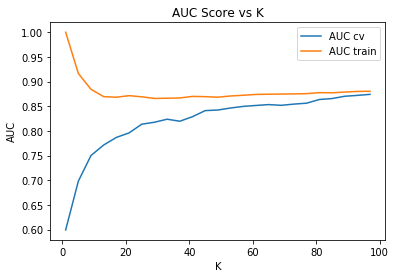

In [56]:
# plotting curve between K vs Train and Cross validation Data
plt.plot(k_value,roc_cv ,label="AUC cv")
plt.plot(k_value,roc_tr,label="AUC train")
plt.legend()
plt.title('AUC Score vs K')
plt.xlabel('K')
plt.ylabel('AUC')
plt.show()

In [57]:
# Training the model using best K    
knn = KNeighborsClassifier(algorithm='brute',metric='minkowski',n_neighbors=k_best)
knn.fit(final_X_tr, y_tr)
#predicting probability on Test data
pred_test = knn.predict_proba(final_X_test)
pred_test=(pred_test)[:,1]
#predicting probablity of Training data
pred_tr = knn.predict_proba(final_X_tr)
pred_tr=(pred_tr)[:,1]

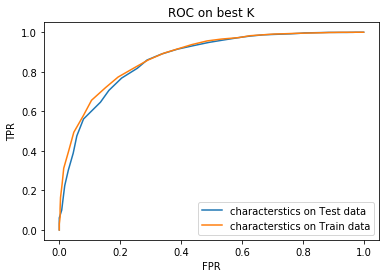

In [58]:
#Plotting Roc Curve

#fiding fpr and tpr on Traing and Test Data
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_test)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr, pred_tr)

#plotting
plt.plot(fpr,tpr ,label="characterstics on Test data")
plt.plot(fpr1,tpr1 ,label="characterstics on Train data")
plt.legend()
plt.title('ROC on best K')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [59]:
#finding Confusion_matrix
predic=knn.predict(final_X_test)
conf_mat = confusion_matrix(y_test, predic)
print(conf_mat)

[[   4  499]
 [   0 2367]]


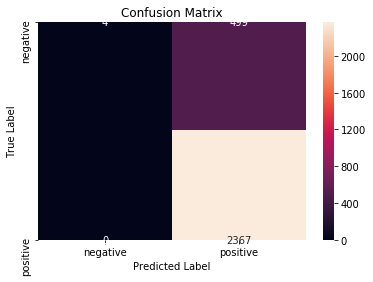

In [60]:
#plotting Confusion Matrix
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.1.3] Applying KNN brute force on AVG W2V

In [61]:
X=preprocessed_reviews
y = np.array(final['Score'])
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3,random_state=1)

# compute average word2vec for each review.
list_of_sentance_tr=[]
for sentance in X_tr:
    list_of_sentance_tr.append(sentance.split())
final_X_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_tr): # for each review/sentence
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    final_X_tr.append(sent_vec)
    
    
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())    
final_X_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    final_X_cv.append(sent_vec)    
    
    
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())    
final_X_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50)
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    final_X_test.append(sent_vec)    


100%|██████████| 2870/2870 [00:03<00:00, 794.53it/s]


In [62]:
#Calculating for finding Best K
roc_tr=[]
roc_cv=[]
k_value=[]
max_auc_score=0
K_best=0
for i in tqdm(range(1,100,4)):
    # instantiate learning model (k = 100)
    knn = KNeighborsClassifier(algorithm='brute',metric='minkowski',n_neighbors=i)

    # fitting the model on train data
    knn.fit(final_X_tr, y_tr)

    # predict the response on the crossvalidation 
    pred_cv = knn.predict_proba(final_X_cv)
    pred_cv=(pred_cv)[:,1]
    roc_cv.append(roc_auc_score(y_cv,pred_cv))
    
     # predict the response on the traininig
    pred_tr = knn.predict_proba(final_X_tr)
    pred_tr=(pred_tr)[:,1]
    roc_tr.append(roc_auc_score(y_tr,pred_tr))
    k_value.append(i)
    
    #finding best k using max value of auc score
    if roc_auc_score(y_cv,pred_cv)>max_auc_score:
        k_best=i
        max_auc_score=roc_auc_score(y_cv,pred_cv)
print("best K is",k_best)
print("max AUC Score is",max_auc_score)
k3=k_best
auc3=max_auc_score

100%|██████████| 25/25 [00:25<00:00,  1.04s/it]


best K is 97
max AUC Score is 0.7200064973739779


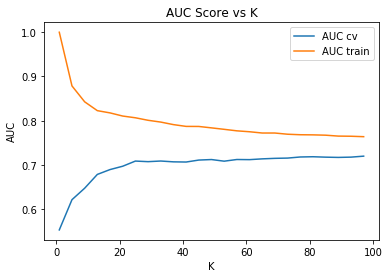

In [63]:
# plotting curve between K vs Train and Cross validation Data
plt.plot(k_value,roc_cv ,label="AUC cv")
plt.plot(k_value,roc_tr,label="AUC train")
plt.legend()
plt.title('AUC Score vs K')
plt.xlabel('K')
plt.ylabel('AUC')
plt.show()

In [64]:
# Training the model using best K    
knn = KNeighborsClassifier(algorithm='brute',metric='minkowski',n_neighbors=k_best)
knn.fit(final_X_tr, y_tr)
#predicting probability on Test data
pred_test = knn.predict_proba(final_X_test)
pred_test=(pred_test)[:,1]
#predicting probablity of Training data
pred_tr = knn.predict_proba(final_X_tr)
pred_tr=(pred_tr)[:,1]

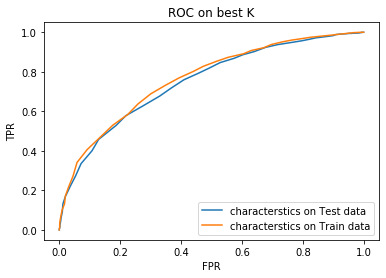

In [65]:
#Plotting Roc Curve

#fiding fpr and tpr on Train and Test Data
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_test)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr, pred_tr)

#plotting
plt.plot(fpr,tpr ,label="characterstics on Test data")
plt.plot(fpr1,tpr1 ,label="characterstics on Train data")
plt.legend()
plt.title('ROC on best K')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [66]:
#finding Confusion_matrix
predic=knn.predict(final_X_test)
conf_mat = confusion_matrix(y_test, predic)
print(conf_mat)

[[   0  503]
 [   0 2367]]


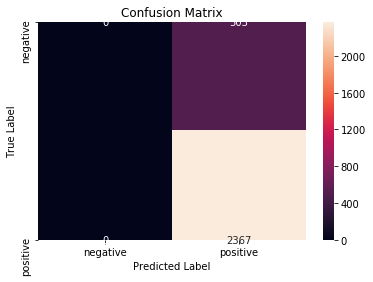

In [68]:
#plotting Confusion Matrix
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.1.4] Applying KNN brute force on TFIDF W2V

In [69]:

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

list_of_sentance_tr=[]
for sentance in X_tr:
    list_of_sentance_tr.append(sentance.split())
final_X_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_tr): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    final_X_tr.append(sent_vec)
    row += 1

    
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
final_X_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    final_X_cv.append(sent_vec)
    row += 1 
    
    
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
final_X_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    final_X_test.append(sent_vec)
    row += 1    

100%|██████████| 2870/2870 [00:18<00:00, 155.12it/s]


In [70]:
#Calculating for finding Best K
roc_tr=[]
roc_cv=[]
k_value=[]
max_auc_score=0
K_best=0
for i in tqdm(range(1,100,4)):
    # instantiate learning model (k = 100)
    knn = KNeighborsClassifier(algorithm='brute',metric='minkowski',n_neighbors=i)

    # fitting the model on train data
    knn.fit(final_X_tr, y_tr)

    # predict the response on the crossvalidation 
    pred_cv = knn.predict_proba(final_X_cv)
    pred_cv=(pred_cv)[:,1]
    roc_cv.append(roc_auc_score(y_cv,pred_cv))
    
     # predict the response on the traininig
    pred_tr = knn.predict_proba(final_X_tr)
    pred_tr=(pred_tr)[:,1]
    roc_tr.append(roc_auc_score(y_tr,pred_tr))
    k_value.append(i)
    
    #finding best k using max value of auc score
    if roc_auc_score(y_cv,pred_cv)>max_auc_score:
        k_best=i
        max_auc_score=roc_auc_score(y_cv,pred_cv)
print("best K is",k_best)
print("max AUC Score is",max_auc_score)
k4=k_best
auc4=max_auc_score

100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


best K is 61
max AUC Score is 0.6853800061364087


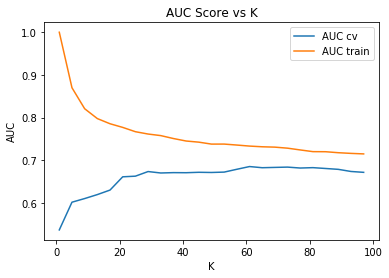

In [72]:
# plotting curve between K vs Train and Cross validation Data
plt.plot(k_value,roc_cv ,label="AUC cv")
plt.plot(k_value,roc_tr,label="AUC train")
plt.legend()
plt.title('AUC Score vs K')
plt.xlabel('K')
plt.ylabel('AUC')
plt.show()

In [73]:
# Training the model using best K    
knn = KNeighborsClassifier(algorithm='brute',metric='minkowski',n_neighbors=k_best)
knn.fit(final_X_tr, y_tr)
#predicting probability on Test data
pred_test = knn.predict_proba(final_X_test)
pred_test=(pred_test)[:,1]
#predicting probablity of Training data
pred_tr = knn.predict_proba(final_X_tr)
pred_tr=(pred_tr)[:,1]

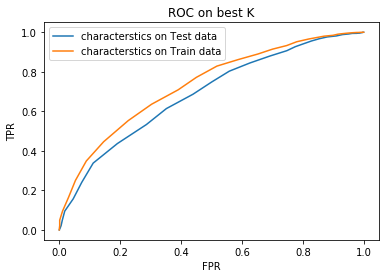

In [74]:
#Plotting Roc Curve

#fiding fpr and tpr on Train and Test Data
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_test)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr, pred_tr)

#plotting
plt.plot(fpr,tpr ,label="characterstics on Test data")
plt.plot(fpr1,tpr1 ,label="characterstics on Train data")
plt.legend()
plt.title('ROC on best K')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [75]:
#finding Confusion_matrix
predic=knn.predict(final_X_test)
conf_mat = confusion_matrix(y_test, predic)
print(conf_mat)

[[   2  501]
 [   3 2364]]


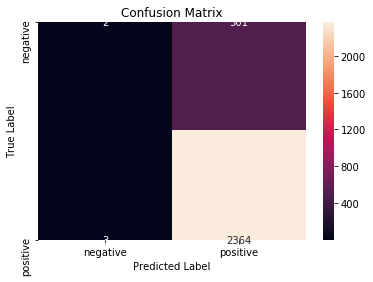

In [76]:
#plotting Confusion Matrix
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW

In [77]:
#Spliting Traing Test and CrossValidation
X=preprocessed_reviews
X=np.array(X)
y = np.array(final['Score'])

X, X_waste, y, y_waste = train_test_split(X, y, test_size=0.70, random_state=1)
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3,random_state=1) 


In [78]:
#converting Reviews to Bag of words
count_vect = CountVectorizer()
final_X_tr=count_vect.fit_transform(X_tr)
final_X_test=count_vect.transform(X_test)
final_X_cv=count_vect.transform(X_cv)

In [79]:
#converting them todense bcz kd tree doest work on sparse matrics
final_X_tr=final_X_tr.todense()
final_X_test=final_X_test.todense()
final_X_cv=final_X_cv.todense()

In [80]:
#Calculating for finding Best K
roc_tr=[]
roc_cv=[]
k_value=[]
max_auc_score=0
K_best=0
for i in tqdm(range(1,100,20)):
    # instantiate learning model (k = 100)
    knn = KNeighborsClassifier(algorithm='kd_tree',metric='minkowski',n_neighbors=i)

    # fitting the model on train data
    knn.fit(final_X_tr, y_tr)

    # predict the response on the crossvalidation 
    pred_cv = knn.predict_proba(final_X_cv)
    pred_cv=(pred_cv)[:,1]
    roc_cv.append(roc_auc_score(y_cv,pred_cv))
    
     # predict the response on the traininig
    pred_tr = knn.predict_proba(final_X_tr)
    pred_tr=(pred_tr)[:,1]
    roc_tr.append(roc_auc_score(y_tr,pred_tr))
    k_value.append(i)
    
    #finding best k using max value of auc score
    if roc_auc_score(y_cv,pred_cv)>max_auc_score:
        k_best=i
        max_auc_score=roc_auc_score(y_cv,pred_cv)
print("best k is",k_best)
print("Max AUC is",max_auc_score)
k5=k_best
auc5=max_auc_score

100%|██████████| 5/5 [02:42<00:00, 32.45s/it]


best k is 41
Max AUC is 0.7275529824854743


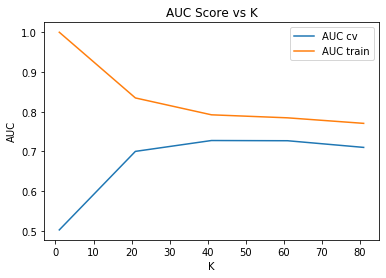

In [81]:
# plotting curve between K vs Train and Cross validation Data
plt.plot(k_value,roc_cv ,label="AUC cv")
plt.plot(k_value,roc_tr,label="AUC train")
plt.legend()
plt.title('AUC Score vs K')
plt.xlabel('K')
plt.ylabel('AUC')
plt.show()

In [82]:
# Training the model using best K    
knn = KNeighborsClassifier(algorithm='kd_tree',metric='minkowski',n_neighbors=k_best)
knn.fit(final_X_tr, y_tr)
#predicting probability on Test data
pred_test = knn.predict_proba(final_X_test)
pred_test=(pred_test)[:,1]
#predicting probablity of Training data
pred_tr = knn.predict_proba(final_X_tr)
pred_tr=(pred_tr)[:,1]


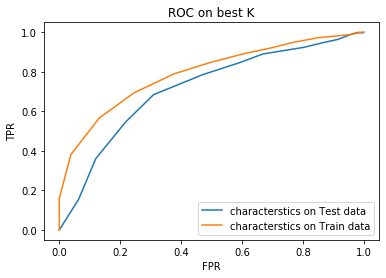

In [83]:
#Plotting Roc Curve

#fiding fpr and tpr on Traing and Test Data
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_test)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr, pred_tr)

#plotting
plt.plot(fpr,tpr ,label="characterstics on Test data")
plt.plot(fpr1,tpr1 ,label="characterstics on Train data")
plt.legend()
plt.title('ROC on best K')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [84]:
#finding Confusion_matrix
predic=knn.predict(final_X_test)
conf_mat = confusion_matrix(y_test, predic)
print(conf_mat)

[[  0 142]
 [  1 718]]


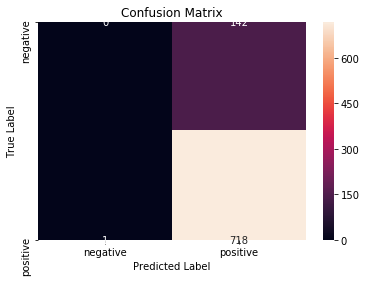

In [85]:
#plotting Confusion Matrix
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.2] Applying KNN kd-tree on TFIDF

In [86]:
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3,random_state=1) 

In [87]:
#converting Reviews to tf_idf_vec
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10)
final_X_tr=tf_idf_vect.fit_transform(X_tr)
final_X_test=tf_idf_vect.transform(X_test)
final_X_cv=tf_idf_vect.transform(X_cv)

#converting them todense bcz kd tree doest work on sparse matrics
final_X_tr=final_X_tr.todense()
final_X_test=final_X_test.todense()
final_X_cv=final_X_cv.todense()

In [88]:
#Calculating for finding Best K
roc_tr=[]
roc_cv=[]
k_value=[]
max_auc_score=0
K_best=0
for i in tqdm(range(1,100,20)):
    # instantiate learning model (k = 100)
    knn = KNeighborsClassifier(algorithm='kd_tree',metric='minkowski',n_neighbors=i)

    # fitting the model on train data
    knn.fit(final_X_tr, y_tr)

    # predict the response on the crossvalidation 
    pred_cv = knn.predict_proba(final_X_cv)
    pred_cv=(pred_cv)[:,1]
    roc_cv.append(roc_auc_score(y_cv,pred_cv))
    
     # predict the response on the traininig
    pred_tr = knn.predict_proba(final_X_tr)
    pred_tr=(pred_tr)[:,1]
    roc_tr.append(roc_auc_score(y_tr,pred_tr))
    k_value.append(i)
    
    #finding best k using max value of auc score
    if roc_auc_score(y_cv,pred_cv)>max_auc_score:
        k_best=i
        max_auc_score=roc_auc_score(y_cv,pred_cv)
print(k_best) 
print(max_auc_score)
k6=k_best
auc6=max_auc_score

100%|██████████| 5/5 [00:23<00:00,  4.64s/it]


81
0.8045395644358985


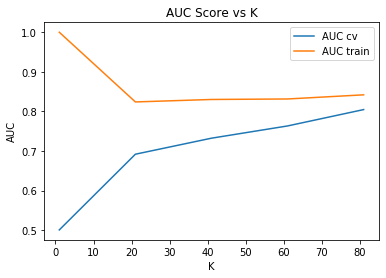

In [89]:
# plotting curve between K vs Train and Cross validation Data
plt.plot(k_value,roc_cv ,label="AUC cv")
plt.plot(k_value,roc_tr,label="AUC train")
plt.legend()
plt.title('AUC Score vs K')
plt.xlabel('K')
plt.ylabel('AUC')
plt.show()

In [90]:
# Training the model using best K    
knn = KNeighborsClassifier(algorithm='kd_tree',metric='minkowski',n_neighbors=k_best)
knn.fit(final_X_tr, y_tr)
#predicting probability on Test data
pred_test = knn.predict_proba(final_X_test)
pred_test=(pred_test)[:,1]
#predicting probablity of Training data
pred_tr = knn.predict_proba(final_X_tr)
pred_tr=(pred_tr)[:,1]

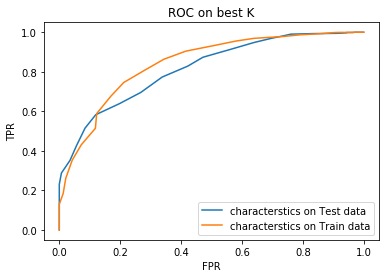

In [91]:
#Plotting Roc Curve

#fiding fpr and tpr on Traing and Test Data
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_test)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr, pred_tr)

#plotting
plt.plot(fpr,tpr ,label="characterstics on Test data")
plt.plot(fpr1,tpr1 ,label="characterstics on Train data")
plt.legend()
plt.title('ROC on best K')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [92]:
#finding Confusion_matrix
predic=knn.predict(final_X_test)
conf_mat = confusion_matrix(y_test, predic)
print(conf_mat)

[[  0 142]
 [  0 719]]


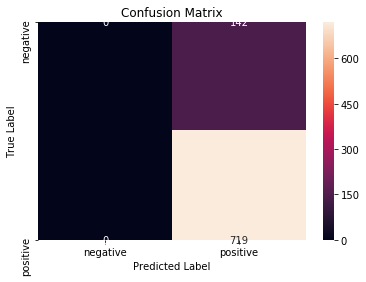

In [93]:
#plotting Confusion Matrix
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.3] Applying KNN kd-tree on AVG W2V

In [94]:
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3,random_state=1)
# average Word2Vec
# compute average word2vec for each review.
list_of_sentance_tr=[]
for sentance in X_tr:
    list_of_sentance_tr.append(sentance.split())
final_X_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_tr): # for each review/sentence
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    final_X_tr.append(sent_vec)
    
    
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())    
final_X_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50)
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    final_X_cv.append(sent_vec)    
    
    
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())    
final_X_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50)
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    final_X_test.append(sent_vec)    


100%|██████████| 861/861 [00:01<00:00, 835.83it/s]


In [95]:
#Calculating for finding Best K
roc_tr=[]
roc_cv=[]
k_value=[]
max_auc_score=0
K_best=0
for i in tqdm(range(1,100,20)):
    # instantiate learning model (k = 100)
    knn = KNeighborsClassifier(algorithm='kd_tree',metric='minkowski',n_neighbors=i)

    # fitting the model on train data
    knn.fit(final_X_tr, y_tr)

    # predict the response on the crossvalidation 
    pred_cv = knn.predict_proba(final_X_cv)
    pred_cv=(pred_cv)[:,1]
    roc_cv.append(roc_auc_score(y_cv,pred_cv))
    
     # predict the response on the traininig
    pred_tr = knn.predict_proba(final_X_tr)
    pred_tr=(pred_tr)[:,1]
    roc_tr.append(roc_auc_score(y_tr,pred_tr))
    k_value.append(i)
    
    #finding best k using max value of auc score
    if roc_auc_score(y_cv,pred_cv)>max_auc_score:
        k_best=i
        max_auc_score=roc_auc_score(y_cv,pred_cv)
print("best K is",k_best)
print("max AUC Score is",max_auc_score)
k7=k_best
auc7=max_auc_score

100%|██████████| 5/5 [00:01<00:00,  4.64it/s]


best K is 81
max AUC Score is 0.7557580570998621


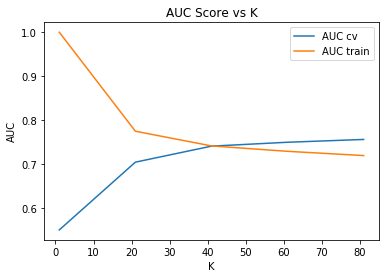

In [96]:
# plotting curve between K vs Train and Cross validation Data
plt.plot(k_value,roc_cv ,label="AUC cv")
plt.plot(k_value,roc_tr,label="AUC train")
plt.legend()
plt.title('AUC Score vs K')
plt.xlabel('K')
plt.ylabel('AUC')
plt.show()

In [97]:
# Training the model using best K    
knn = KNeighborsClassifier(algorithm='kd_tree',metric='minkowski',n_neighbors=k_best)
knn.fit(final_X_tr, y_tr)
#predicting probability on Test data
pred_test = knn.predict_proba(final_X_test)
pred_test=(pred_test)[:,1]
#predicting probablity of Training data
pred_tr = knn.predict_proba(final_X_tr)
pred_tr=(pred_tr)[:,1]

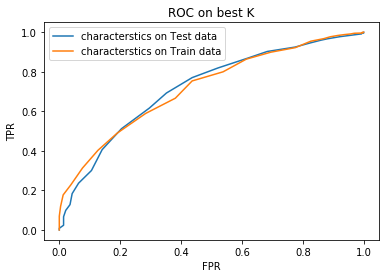

In [98]:
#Plotting Roc Curve

#fiding fpr and tpr on Train and Test Data
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_test)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr, pred_tr)

#plotting
plt.plot(fpr,tpr ,label="characterstics on Test data")
plt.plot(fpr1,tpr1 ,label="characterstics on Train data")
plt.legend()
plt.title('ROC on best K')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [99]:
#finding Confusion_matrix
predic=knn.predict(final_X_test)
conf_mat = confusion_matrix(y_test, predic)
print(conf_mat)

[[  0 142]
 [  0 719]]


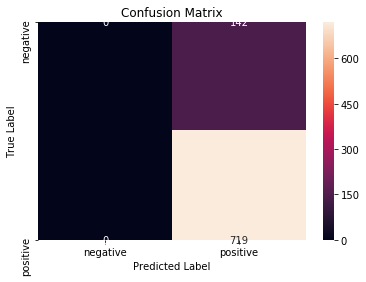

In [100]:
#plotting Confusion Matrix
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.4] Applying KNN kd-tree on TFIDF W2V

In [101]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

list_of_sentance_tr=[]
for sentance in X_tr:
    list_of_sentance_tr.append(sentance.split())
final_X_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_tr): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    final_X_tr.append(sent_vec)
    row += 1

    
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
final_X_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf values of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    final_X_cv.append(sent_vec)
    row += 1 
    
    
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
final_X_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    final_X_test.append(sent_vec)
    row += 1    

100%|██████████| 861/861 [00:05<00:00, 157.57it/s]


In [102]:
#Calculating for finding Best K
roc_tr=[]
roc_cv=[]
k_value=[]
max_auc_score=0
K_best=0
for i in tqdm(range(1,100,20)):
    # instantiate learning model (k = 100)
    knn = KNeighborsClassifier(algorithm='kd_tree',metric='minkowski',n_neighbors=i)

    # fitting the model on train data
    knn.fit(final_X_tr, y_tr)

    # predict the response on the crossvalidation 
    pred_cv = knn.predict_proba(final_X_cv)
    pred_cv=(pred_cv)[:,1]
    roc_cv.append(roc_auc_score(y_cv,pred_cv))
    
     # predict the response on the traininig
    pred_tr = knn.predict_proba(final_X_tr)
    pred_tr=(pred_tr)[:,1]
    roc_tr.append(roc_auc_score(y_tr,pred_tr))
    k_value.append(i)
    
    #finding best k using max value of auc score
    if roc_auc_score(y_cv,pred_cv)>max_auc_score:
        k_best=i
        max_auc_score=roc_auc_score(y_cv,pred_cv)
print("best K is",k_best)
print("max AUC Score is",max_auc_score)
k8=k_best
auc8=max_auc_score

100%|██████████| 5/5 [00:01<00:00,  4.57it/s]


best K is 81
max AUC Score is 0.6721565021109392


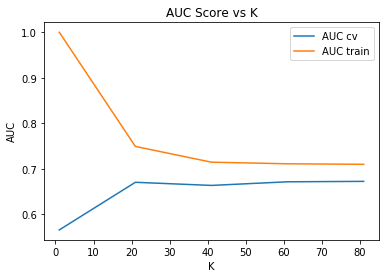

In [103]:
# plotting curve between K vs Train and Cross validation Data
plt.plot(k_value,roc_cv ,label="AUC cv")
plt.plot(k_value,roc_tr,label="AUC train")
plt.legend()
plt.title('AUC Score vs K')
plt.xlabel('K')
plt.ylabel('AUC')
plt.show()

In [104]:
# Training the model using best K    
knn = KNeighborsClassifier(algorithm='kd_tree',metric='minkowski',n_neighbors=k_best)
knn.fit(final_X_tr, y_tr)
#predicting probability on Test data
pred_test = knn.predict_proba(final_X_test)
pred_test=(pred_test)[:,1]
#predicting probablity of Training data
pred_tr = knn.predict_proba(final_X_tr)
pred_tr=(pred_tr)[:,1]

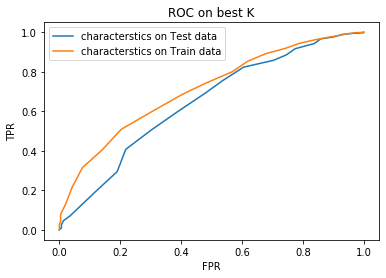

In [105]:
#Plotting Roc Curve

#fiding fpr and tpr on Train and Test Data
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_test)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr, pred_tr)

#plotting
plt.plot(fpr,tpr ,label="characterstics on Test data")
plt.plot(fpr1,tpr1 ,label="characterstics on Train data")
plt.legend()
plt.title('ROC on best K')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [106]:
#finding Confusion_matrix
predic=knn.predict(final_X_test)
conf_mat = confusion_matrix(y_test, predic)
print(conf_mat)

[[  0 142]
 [  0 719]]


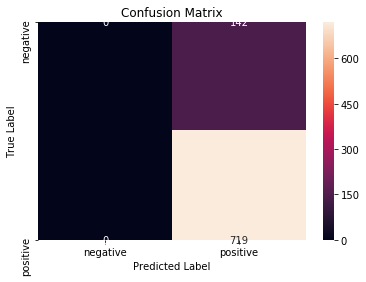

In [109]:
#plotting Confusion Matrix
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# [6] Conclusions

In [116]:
# comparing all models using Prettytable library
from tabulate import tabulate   
print(tabulate([["Vectorizer", "Model", "Hyperameter", "AUC"],["BOW","Brute",k1,auc1],["TFIDF","Brute",k2,auc2],["AwgW2V","Brute",k3,auc3],["TFIDF W2V","Brute",k4,auc4],["BOW","k_d tree",k5,auc5],["TFIDF","k_d tree",k6,auc6],["AwgW2V","k_d tree",k7,auc7],["TFIDF W2V","k_d tree",k8,auc8]], headers="firstrow"))




Vectorizer    Model       Hyperameter       AUC
------------  --------  -------------  --------
BOW           Brute                73  0.729983
TFIDF         Brute                97  0.874117
AwgW2V        Brute                97  0.720006
TFIDF W2V     Brute                61  0.68538
BOW           k_d tree             41  0.727553
TFIDF         k_d tree             81  0.80454
AwgW2V        k_d tree             81  0.755758
TFIDF W2V     k_d tree             81  0.672157


### We conclude that Brute model of KNN with TFIDF vectorizing gives us the best accuracy of 0.874117 . 